In [1]:
import os

datadir = "/home/ymerel/fmri/OHBM_2026_neurovariants/data/emotion_1000"
ds_path = os.path.join(datadir, 'dataset.csv')
corr_path = os.path.join(datadir, 'correlations.csv')
corr_func = 'pearson'
basedir = "/home/ymerel/storage/results/"
jobname = "emotion_1000"
result_path = f"{basedir}{jobname}"
coords = [-20, -6, -16]

In [2]:
!sshfs -o reconnect,ServerAliveInterval=120,ServerAliveCountMax=3 rennes.g5k:/srv/storage/empenn@storage2.rennes.grid5000.fr/private/ymerel /home/ymerel/storage

fusermount3: failed to access mountpoint /home/ymerel/storage: Permission denied


In [3]:
import pandas as pd

def normalize_dataset(ds: pd.DataFrame):
    
    str_alternatives = {
        "motion_correction_realignment/register_to" : ["first", "mean"],
        "coregistration/source_target" : ["anat_on_func", "func_on_anat"],
        "coregistration/cost_function" : ["mutual_information", "normalised_mutual_information", "entropy_correlation_coefficient", "normalised_cross_correlation"],
        "spatial_normalization/template" : ["Ixi549Space", "MNI305", "MNI152_linear", "MNI152_nonlinear"],
        "spatial_normalization/algorithm" : ["linear", "nonlinear", "DARTEL"],
        "spatial_normalization/interpolation" : ["nearest_neighbour", "trilinear", "bspline"],
        "slice_timing_correction/ref_slice" : ["first", "middle"],
        "signal_modeling/hrf" : ["canonical", "temporal_derivs", "temporal_dispersion_derivs"],
        "signal_modelling/temporal_noise_autocorrelation" : ["AR1", "FAST"],
    }

    num_alternatives = {
        "spatial_normalization/bias_fwhm" : [30, 40, 60, 70, 80, 90, 100, 110, 120,130,140,150],
        "spatial_smoothing/fwhm" : [2, 4, 6, 8, 10, 12, 14],
        "signal_modeling/nuisance_regressors/motion" : [6, 18, 24]
    }
    
    bias_regs = {
            'extremely_light': 0.00001,
            'very_light': 0.0001,
            'light': 0.001,
            'medium': 0.01,
            'heavy': 0.1
        }
    
    # change column types
    for col in num_alternatives:
        ds[col] = ds[col].astype(int)
    for col in bias_regs:
        ds[f"spatial_normalization/bias_regularisation/{col}"] = ds[f"spatial_normalization/bias_regularisation/{col}"].astype(float)
    
    for index, row in ds.iterrows():
        for feature, values in num_alternatives.items():
            if row[feature] is False:
                ds.at[index, feature] = 0
                continue
            for val in values:
                alt = f"{feature}/{val}"
                if row[alt] is True:
                    ds.at[index, feature] = val
        for label, value in bias_regs.items():
            if row[f"spatial_normalization/bias_regularisation/{label}"] is True:
                ds.at[index, "spatial_normalization/bias_regularisation"] = value
    
    for key in num_alternatives:
        for val in num_alternatives[key]:
            ds = ds.drop(f"{key}/{val}",  axis=1)
    ds = ds.convert_dtypes()
    boolean_columns = ds.select_dtypes(include='bool').columns
    columns_to_drop = [col for col in boolean_columns if ds[col].all()]
    columns_to_drop.append("pearson_from_mean")
    columns_to_drop.append("spearman_from_mean")
    columns_to_drop.append("spearman_from_ref")
    ds = ds.drop(columns=columns_to_drop)
    ds.rename(columns={f'{corr_func}_from_ref': 'from_ref'}, inplace=True)
    return ds

# Load data

In [4]:
# load correlations
correlations = pd.read_csv(corr_path, delimiter=';')
print(len(correlations))
matrix = correlations.pivot(index='source', columns='target', values=corr_func).fillna(1.0)
distance_matrix = 1 - matrix

dataset = pd.read_csv(ds_path, delimiter=';')
dataset = normalize_dataset(dataset)

dataset.head(1010)

1004004


,coregistration/source_target/func_on_anat,signal_modeling/nuisance_regressors,motion_correction_realignment/register_to/mean,coregistration/cost_function/normalised_mutual_information,motion_correction_realignment/register_to/first,signal_modelling/temporal_noise_autocorrelation/FAST,spatial_normalization/template/MNI152_linear,spatial_normalization/interpolation/trilinear,spatial_normalization/template/MNI305,spatial_normalization/algorithm/linear,...,slice_timing_correction/tool,spatial_normalization/interpolation/bspline,spatial_normalization/bias_regularisation/heavy,slice_timing_correction,slice_timing_correction/tool/spm,slice_timing_correction/ref_slice/first,coregistration/source_target/anat_on_func,spatial_normalization/template/MNI152_nonlinear,id,from_ref
0,False,True,True,True,False,False,False,False,False,False,...,True,True,0,True,True,False,True,False,3c05066eec67a15033be163c0f9ff11b5c10fd45cd65ba...,0.900965
1,False,True,True,True,False,False,False,True,False,False,...,True,False,0,True,True,True,True,False,6a45076ef4e7d5e2e19b1eff4c2400f12820aff5f5de35...,0.962165
2,False,True,True,False,False,True,False,True,False,False,...,True,False,0,True,True,True,True,False,a81f94290b1b4f571a07d9b91a109579ee7d03659cdf52...,0.941414
3,True,True,False,True,True,True,False,False,False,False,...,True,True,0,True,True,True,False,False,2f1b0cc3775d7509fd40c6014f1108f47283fdbc41def5...,0.310484
4,True,False,True,True,False,True,False,False,False,False,...,True,True,0,True,True,True,False,False,2b180b74b0da6eecd34b48ced760ce60b597d2ab968204...,0.262319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,True,True,True,False,False,True,False,False,False,False,...,False,False,0,False,False,False,False,False,d525a785bbd64a3e00a80437c26b9713e674a6534e7c38...,0.250972
996,False,True,True,False,False,False,False,False,False,False,...,False,True,0,False,False,False,True,False,59f2ff57b0b98f94f4fa0c8ca60f1825d2dc4e36c726e1...,0.470753
997,False,False,False,False,True,False,False,False,False,False,...,True,True,0,True,True,True,True,False,b113529b25ad5d523e71aa871814dd6488422ed4e99bcd...,0.788285
998,False,True,True,False,False,False,False,True,False,False,...,True,False,0,True,True,True,True,False,b37758404e40f9dea67fbd21cea525377ab19ba18e09af...,0.53838


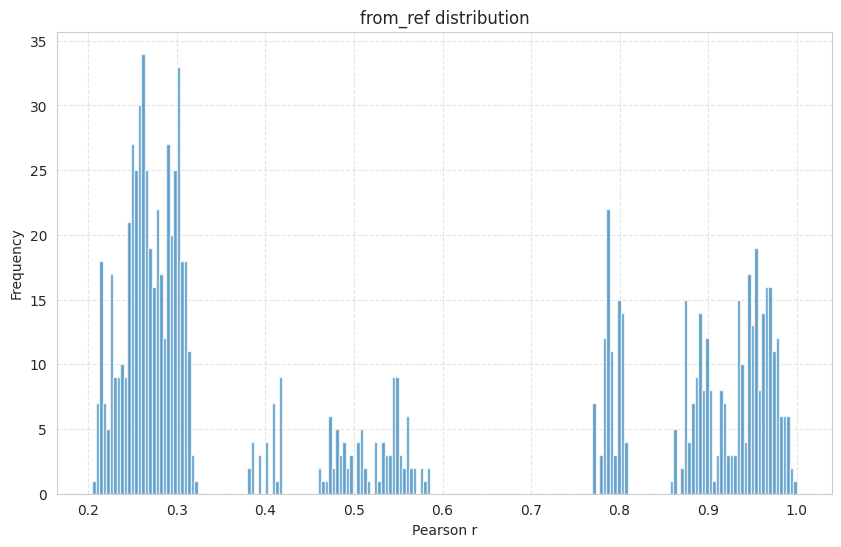

/home/ymerel/tmp/ipykernel_23822/3804470831.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sb.kdeplot(dataset['from_ref'], shade=True, color='blue')


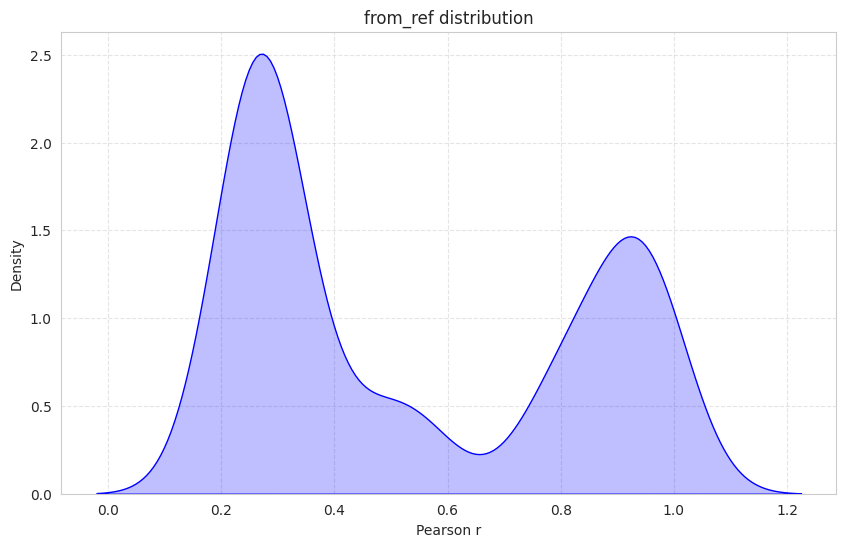

In [5]:
import seaborn as sb
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(dataset['from_ref'], bins=200, alpha=0.7)
plt.title('from_ref distribution')
plt.xlabel('Pearson r')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

plt.figure(figsize=(10, 6))
sb.kdeplot(dataset['from_ref'], shade=True, color='blue')
plt.title('from_ref distribution')
plt.xlabel('Pearson r')
plt.ylabel('Density')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Compare correlations metrics
Evaluate distribution of values for Pearson, spearman, jaccard, dice
Compare Pearson vs Spearman

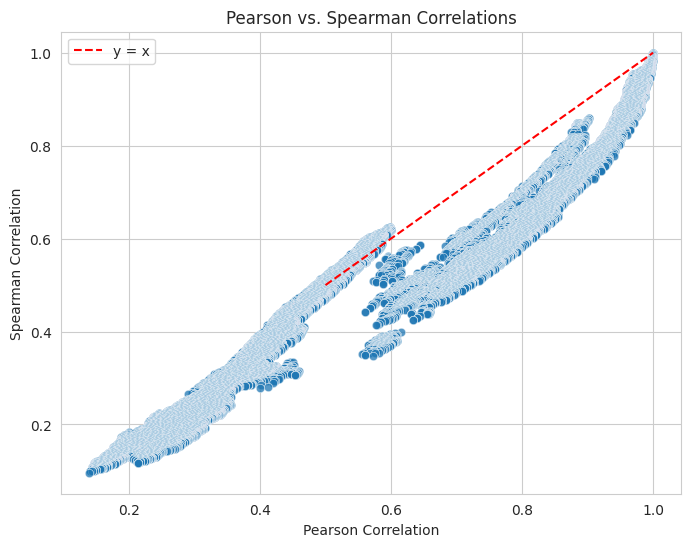

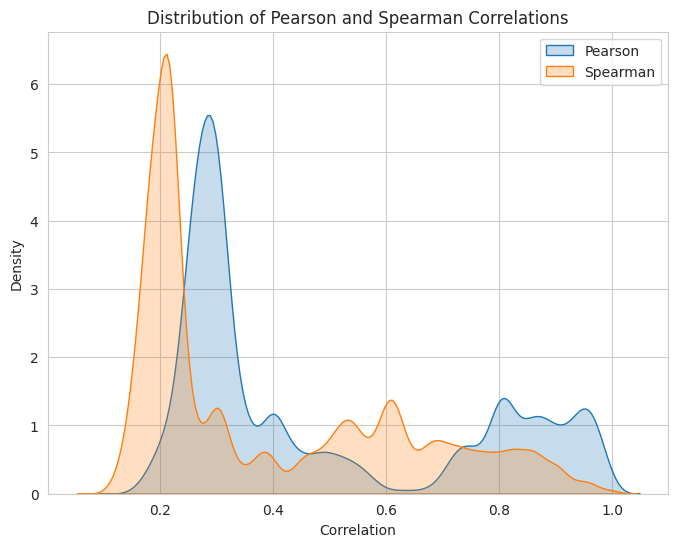

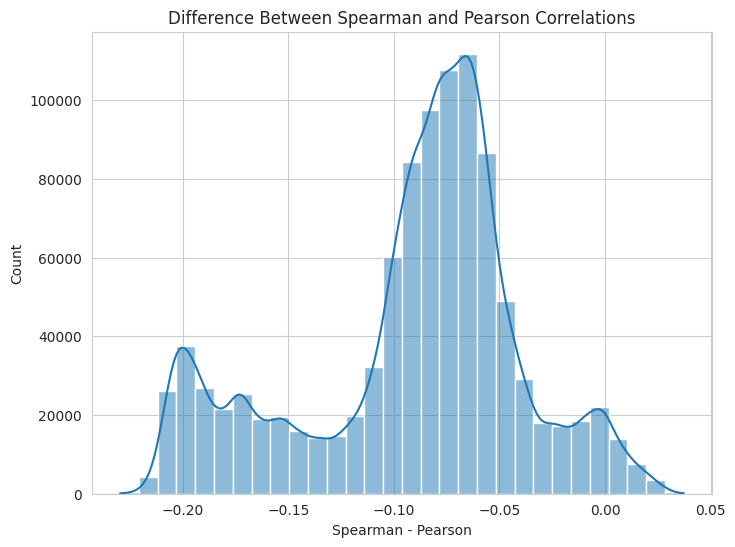

In [6]:
import matplotlib.pyplot as plt
import seaborn as sb

plt.figure(figsize=(8, 6))
sb.scatterplot(data=correlations, x="pearson", y="spearman", alpha=0.5)
plt.plot([0.5, 1], [0.5, 1], 'r--', label="y = x")  # Diagonal line
plt.xlabel("Pearson Correlation")
plt.ylabel("Spearman Correlation")
plt.title("Pearson vs. Spearman Correlations")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
sb.kdeplot(data=correlations, x="pearson", label="Pearson", fill=True)
sb.kdeplot(data=correlations, x="spearman", label="Spearman", fill=True)
plt.xlabel("Correlation")
plt.ylabel("Density")
plt.title("Distribution of Pearson and Spearman Correlations")
plt.legend()
plt.show()

correlations["difference"] = correlations["spearman"] - correlations["pearson"]

plt.figure(figsize=(8, 6))
sb.histplot(data=correlations, x="difference", bins=30, kde=True)
plt.xlabel("Spearman - Pearson")
plt.ylabel("Count")
plt.title("Difference Between Spearman and Pearson Correlations")
plt.show()

# Clusterize

## Cluster by threshold

In [7]:
from utils import clusterize_hierch, predict_clusters, get_cluster_distance_densities, get_cluster_cophenetic,get_cluster_silhouette, get_cluster_inertia, get_davies_bouldin, get_medoids, get_antimedoids
import numpy as np

all_results = []

thresholds = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.5, 0.55, 0.60, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

for threshold in thresholds:
    results = dict()
    results['threshold'] = threshold
    # cluster on whole dataset
    ds, matrix, Z, clusters = clusterize_hierch(dataset, correlations, dataset['id'], None, corr_func, threshold)
    results['clusters'] = len(np.unique(clusters.values))
    
    distance_matrix = 1 - matrix
    densities = get_cluster_distance_densities(distance_matrix.values, clusters.values)
    results['mean_density'] = np.mean(list(densities.values()))
    results['cophenetic'] = get_cluster_cophenetic(Z, distance_matrix.values)
    results['silhouette'] = get_cluster_silhouette(distance_matrix.values, clusters.values)
    results['davies_bouldin'] = get_davies_bouldin(distance_matrix.values, clusters.values)
    results['inertia'] = get_cluster_inertia(distance_matrix.values, clusters.values)
    results['medoids'] = get_medoids(distance_matrix, clusters)
    results['antimedoids'] = get_antimedoids(distance_matrix, clusters)
    # predict on 70 % train dataset
    merged_results = results | predict_clusters(dataset, correlations, None, corr_func, threshold, 0.7)
    all_results.append(merged_results)
df_by_thresh = pd.DataFrame(all_results)

/home/ymerel/fmri/OHBM_2026_neurovariants/utils.py:110: RuntimeWarning: invalid value encountered in scalar divide
  avg_dist = (np.sum(cluster_dist) - np.sum(np.diag(cluster_dist))) / (cluster_dist.size - len(cluster_dist))


## Print all metrics
- Cophenetic correlation: > 0.75 = good ; < 0.75 = poor
- Silhouette score: -1 = worst ; 1 = best
- Davies-Bouldin index: < 1 = good
- Inertia: lower = tighter

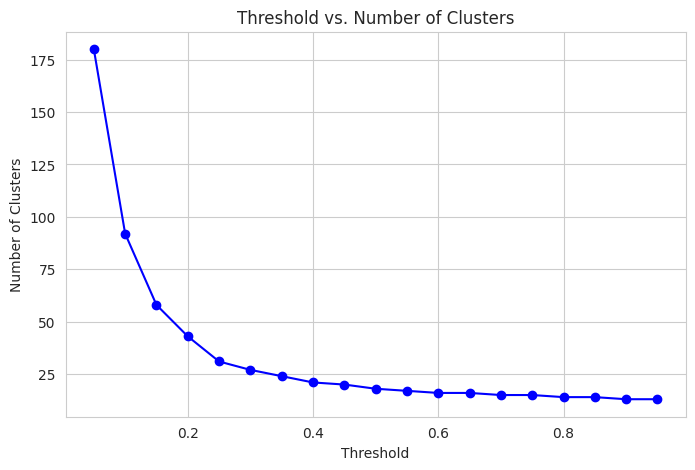

,threshold,clusters,mean_density,cophenetic,silhouette,davies_bouldin,inertia,medoids,antimedoids,train_size,accuracy,recall,decision_tree,feature_importances
0,0.05,180,NaN,0.959161,0.540857,0.946800,1.459888,{52: '9a4b73f18251186470f127dae14ad43d76d4c4ab...,{52: 'caff1df6c3ecf339562ca4a012365bfcf2cf4ab7...,0.7,0.836667,0.748593,"digraph Tree {\nnode [shape=box, style=""filled...",{'coregistration/source_target/func_on_anat': ...
1,0.10,92,0.024313,0.959161,0.474484,1.081654,9.170226,{25: 'cde2754261cd7bfee360163133d086291eecd510...,{25: '7dc5a3eaabfc3d38cfdb08137b9ae089e21c0e52...,0.7,0.890000,0.766527,"digraph Tree {\nnode [shape=box, style=""filled...",{'coregistration/source_target/func_on_anat': ...
2,0.15,58,0.033567,0.959161,0.442354,1.193763,23.120569,{14: 'cde2754261cd7bfee360163133d086291eecd510...,{14: '7dc5a3eaabfc3d38cfdb08137b9ae089e21c0e52...,0.7,0.936667,0.906845,"digraph Tree {\nnode [shape=box, style=""filled...",{'coregistration/source_target/func_on_anat': ...
3,0.20,43,0.037829,0.959161,0.462306,1.111026,46.985570,{16: 'febc17b58590f530561694b99be22be77c24e633...,{16: '7dc5a3eaabfc3d38cfdb08137b9ae089e21c0e52...,0.7,0.996667,0.988095,"digraph Tree {\nnode [shape=box, style=""filled...",{'coregistration/source_target/func_on_anat': ...
4,0.25,31,0.043097,0.959161,0.520418,0.957498,92.041985,{11: 'febc17b58590f530561694b99be22be77c24e633...,{11: '7dc5a3eaabfc3d38cfdb08137b9ae089e21c0e52...,0.7,0.980000,0.981077,"digraph Tree {\nnode [shape=box, style=""filled...",{'coregistration/source_target/func_on_anat': ...
5,0.30,27,0.045819,0.959161,0.540439,0.881077,123.248786,{10: 'febc17b58590f530561694b99be22be77c24e633...,{10: '7dc5a3eaabfc3d38cfdb08137b9ae089e21c0e52...,0.7,0.996667,0.997151,"digraph Tree {\nnode [shape=box, style=""filled...",{'coregistration/source_target/func_on_anat': ...
6,0.35,24,0.048027,0.959161,0.546868,0.851539,159.812848,{9: 'febc17b58590f530561694b99be22be77c24e6331...,{9: '7dc5a3eaabfc3d38cfdb08137b9ae089e21c0e52a...,0.7,0.990000,0.992647,"digraph Tree {\nnode [shape=box, style=""filled...",{'coregistration/source_target/func_on_anat': ...
7,0.40,21,0.049189,0.959161,0.576617,0.692662,222.411891,{8: 'febc17b58590f530561694b99be22be77c24e6331...,{8: '7dc5a3eaabfc3d38cfdb08137b9ae089e21c0e52a...,0.7,1.000000,1.000000,"digraph Tree {\nnode [shape=box, style=""filled...",{'coregistration/source_target/func_on_anat': ...
8,0.45,20,0.052852,0.959161,0.572043,0.715598,228.206899,{8: 'febc17b58590f530561694b99be22be77c24e6331...,{8: '7dc5a3eaabfc3d38cfdb08137b9ae089e21c0e52a...,0.7,1.000000,1.000000,"digraph Tree {\nnode [shape=box, style=""filled...",{'coregistration/source_target/func_on_anat': ...
9,0.50,18,0.055602,0.959161,0.612148,0.639608,326.605498,{6: 'febc17b58590f530561694b99be22be77c24e6331...,{6: '7dc5a3eaabfc3d38cfdb08137b9ae089e21c0e52a...,0.7,1.000000,1.000000,"digraph Tree {\nnode [shape=box, style=""filled...",{'coregistration/source_target/func_on_anat': ...


In [8]:
df_results = df_by_thresh
plt.figure(figsize=(8, 5))
plt.plot(df_results['threshold'], df_results['clusters'], marker='o', linestyle='-', color='b')
plt.title('Threshold vs. Number of Clusters')
plt.xlabel('Threshold')
plt.ylabel('Number of Clusters')
plt.grid(True)
plt.show()
df_results.head(20)

## Identify incorrect clusters by medoids

Cluster [1] - Medoid [175aba5e213089daa24c32d5cb3c34193538db2a394fe7956eec838c924b11d5]


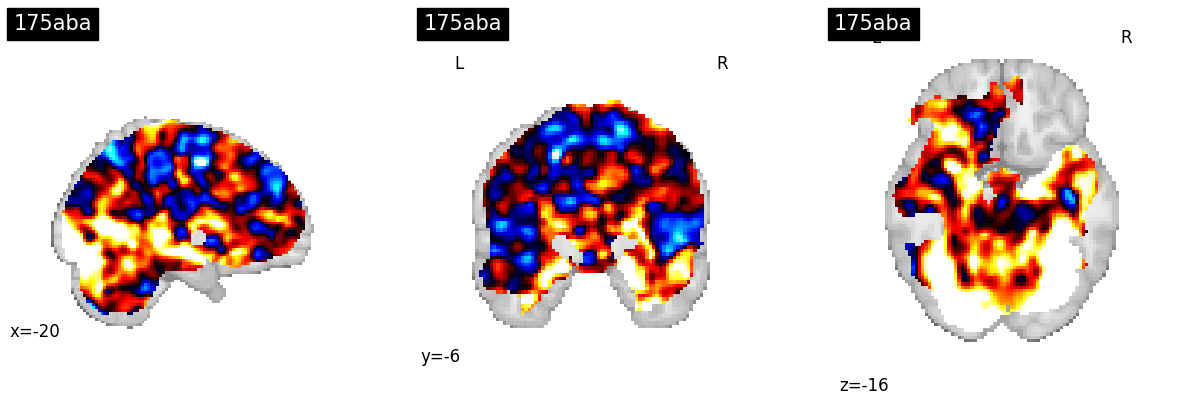

Cluster [1] - Antimedoid


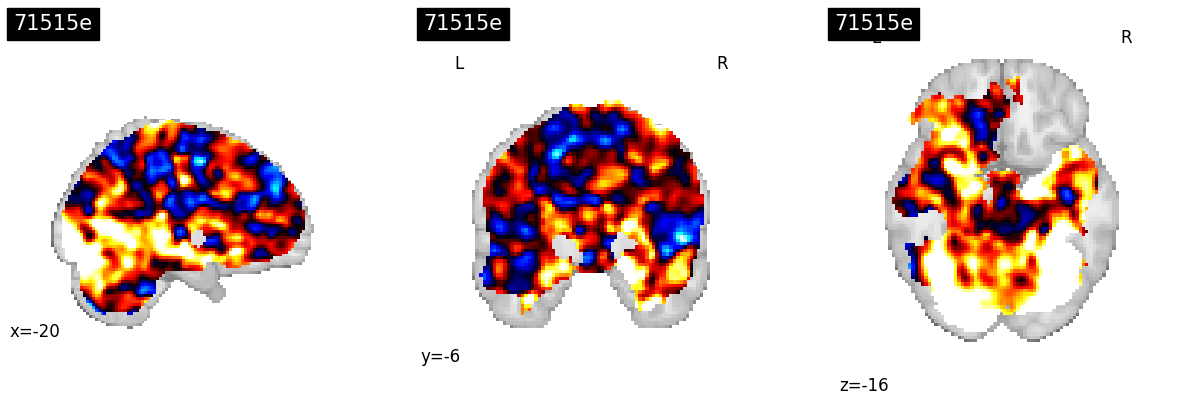

Cluster [2] - Medoid [9111a94c1a55f876b2a92dfa6466af0879e5b3487240c5ebf816502c3366b1d5]


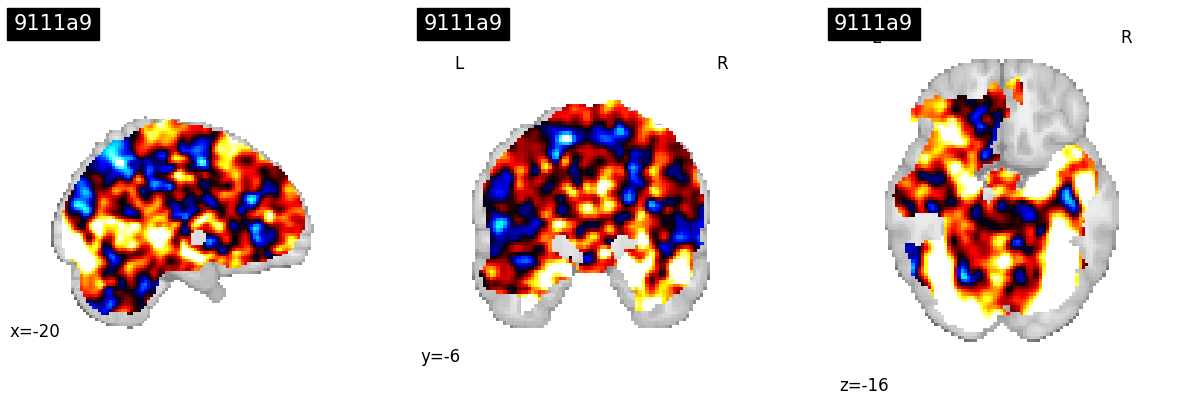

Cluster [2] - Antimedoid


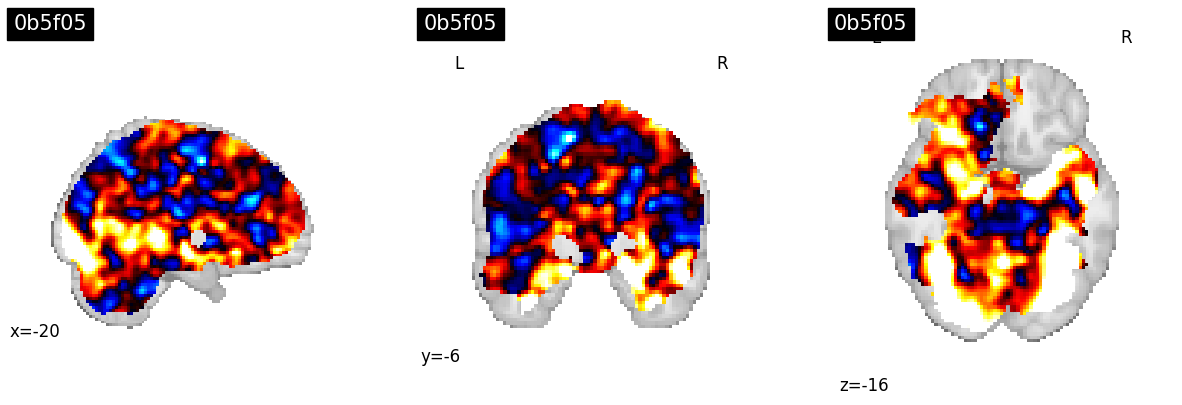

Cluster [3] - Medoid [b10ba27b41c72cecd805fe36c225741ff4fd50f1f9f734d027a7de9a13d74ad5]


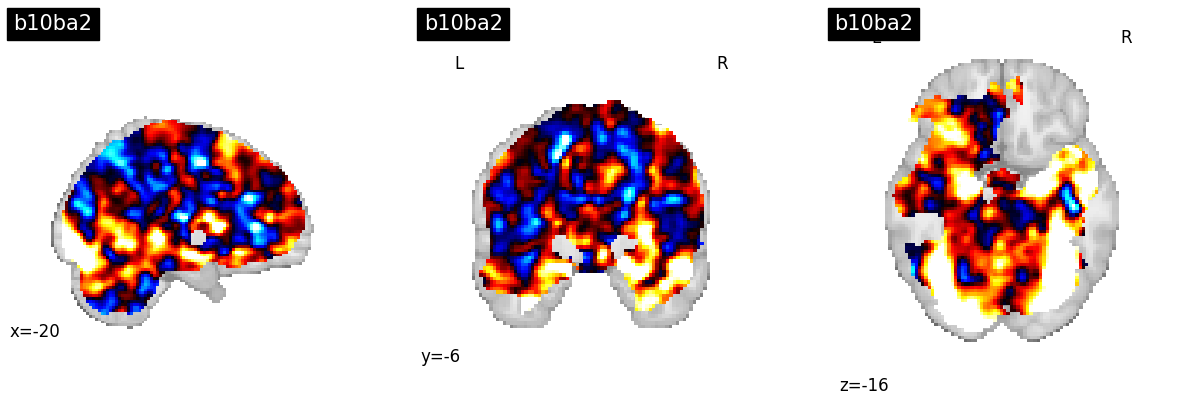

Cluster [3] - Antimedoid


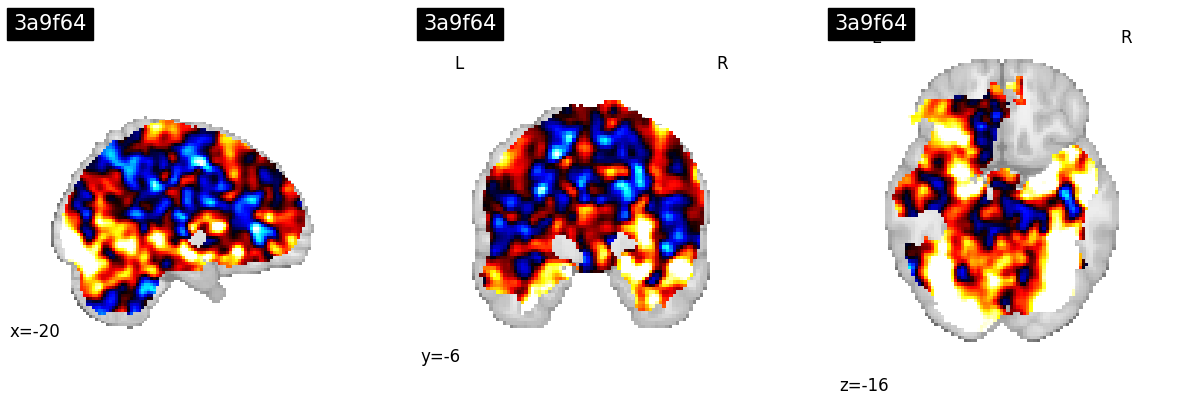

Cluster [4] - Medoid [ca81820a90f00d9e3284c450342d948e5e2ddd564d4b5447c417cf7176d6a6b0]


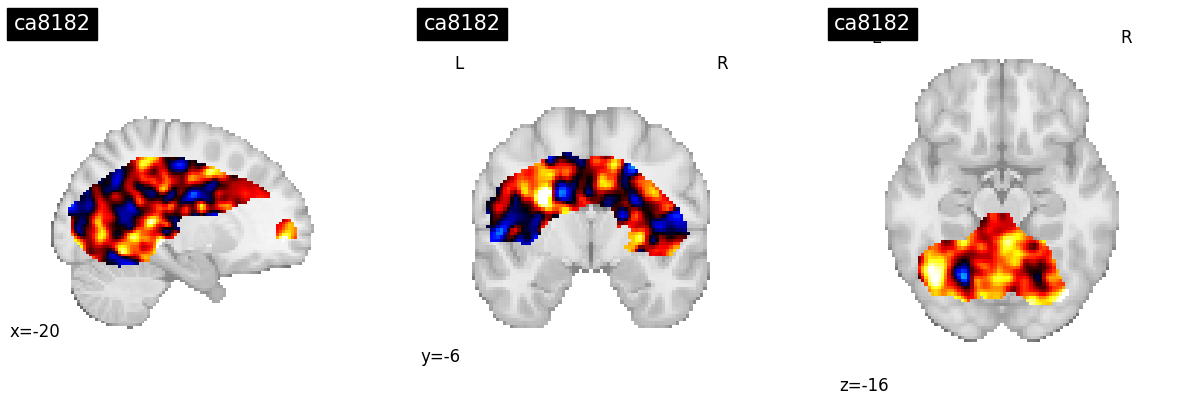

Cluster [4] - Antimedoid


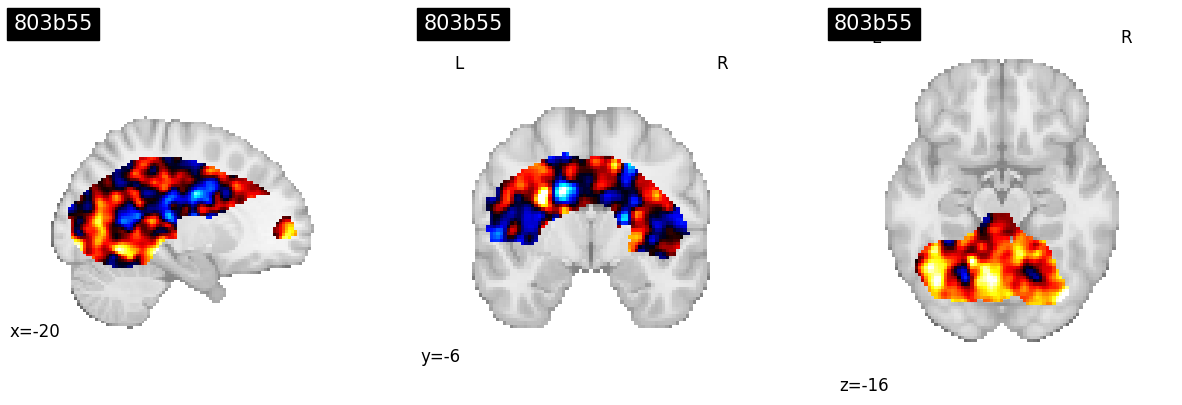

Cluster [5] - Medoid [b167b97f4dda778f5d683f913d9a078cb98218a42084e826c6336d58bc203322]


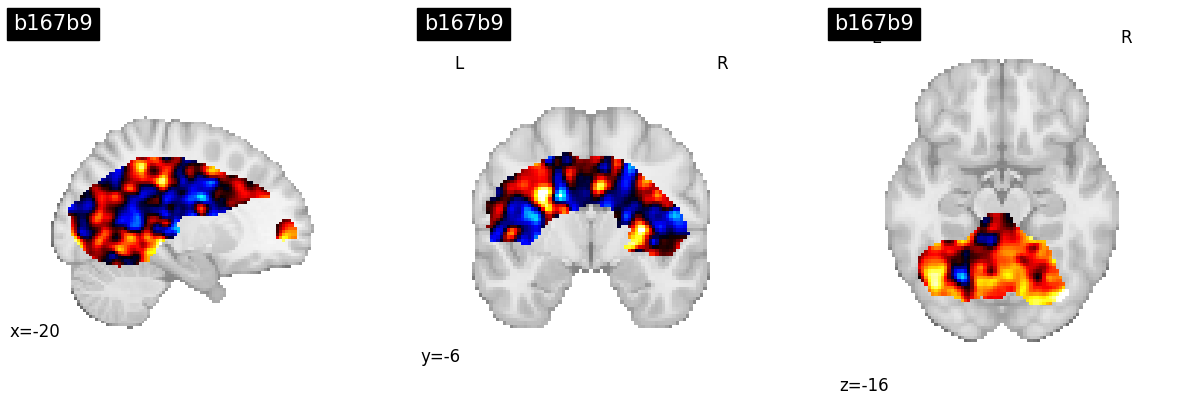

Cluster [5] - Antimedoid


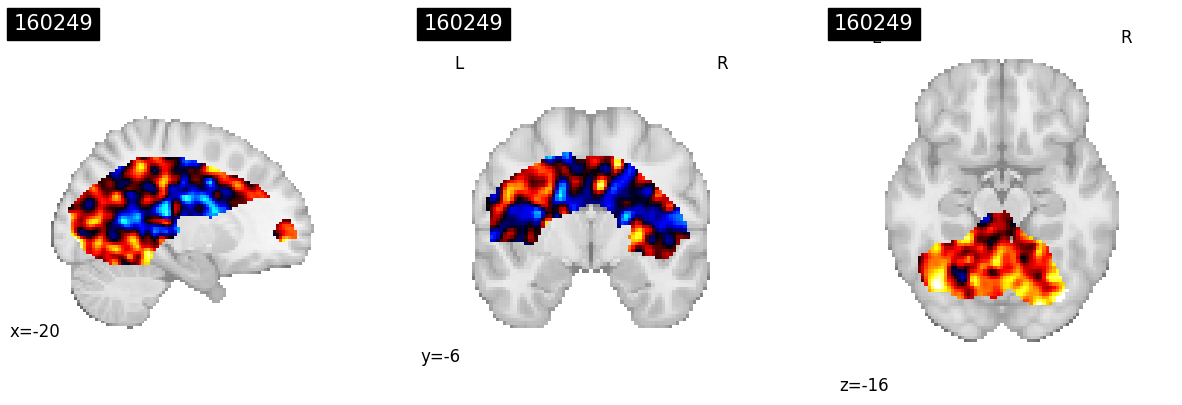

Cluster [6] - Medoid [febc17b58590f530561694b99be22be77c24e6331756d569e2e0049356259abd]


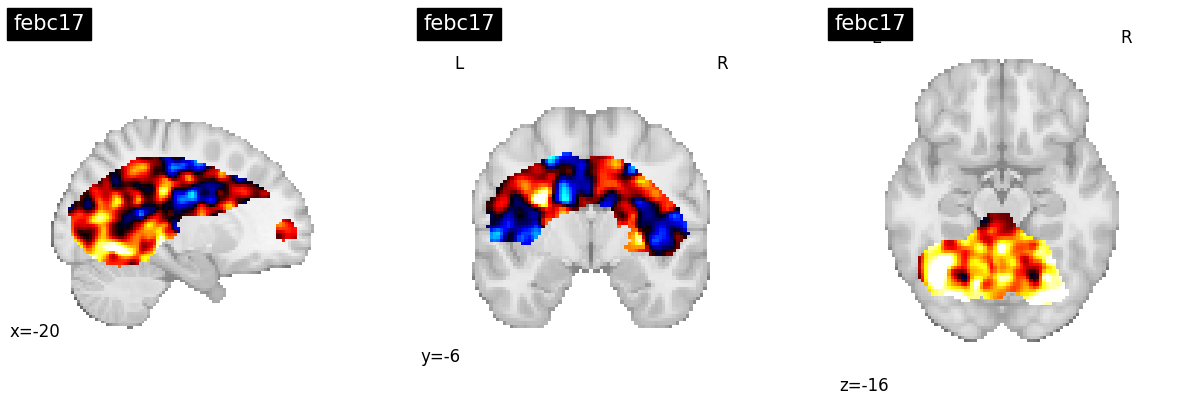

Cluster [6] - Antimedoid


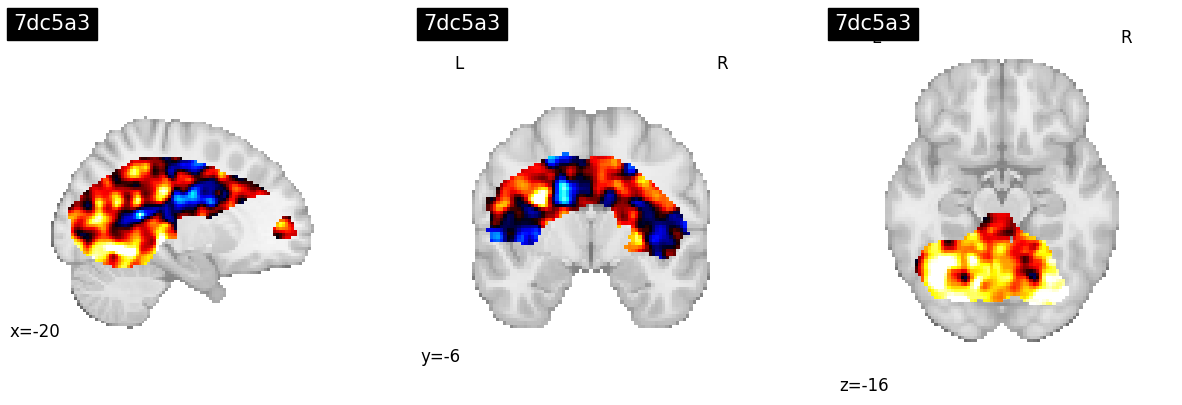

Cluster [7] - Medoid [4d96c84b4fe3cbe2d86332981a2ba16ff3c15b6425346f10a99ff2b204d6587b]


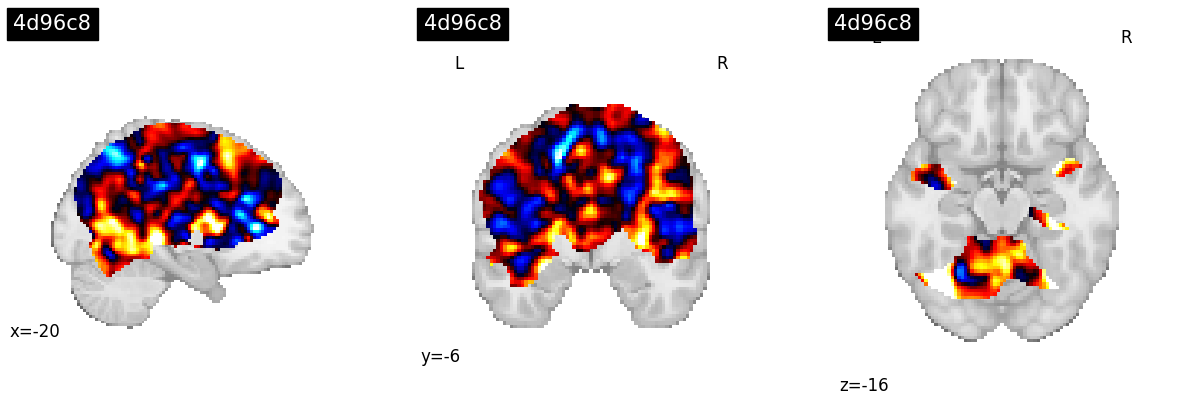

Cluster [7] - Antimedoid


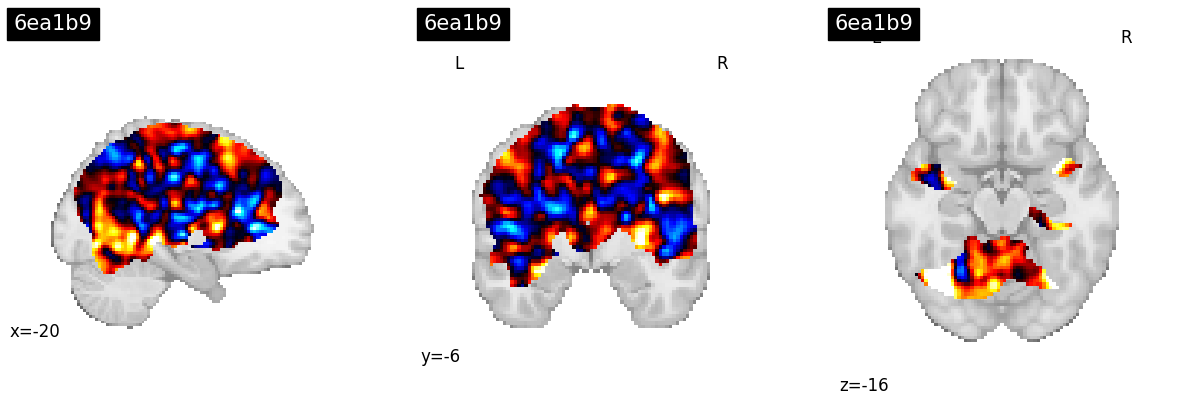

Cluster [8] - Medoid [125dc798401385965e556a03d711af52cb6b10f250a488f6be16c86fe5e78019]


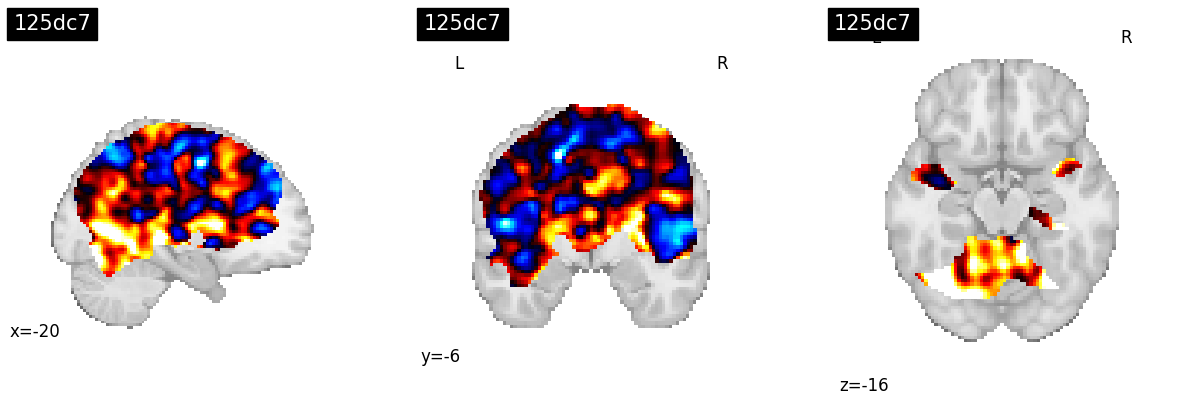

Cluster [8] - Antimedoid


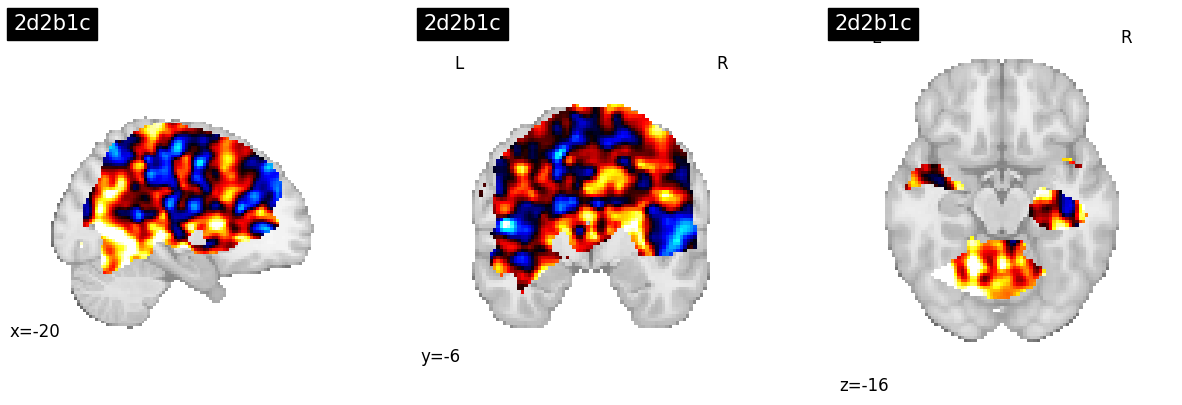

Cluster [9] - Medoid [ef9c96bb413750b89292cfa1af757fd95e86d595ac4039cab497b77310abdae6]


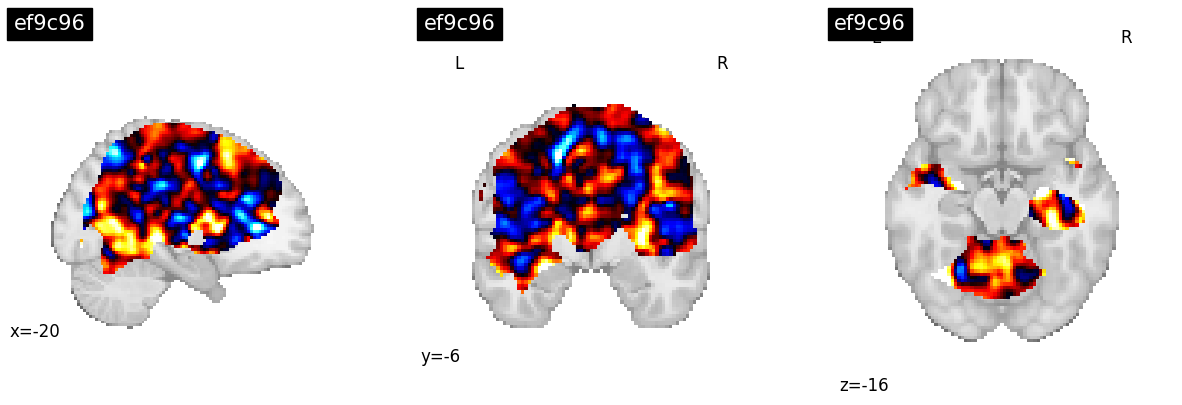

Cluster [9] - Antimedoid


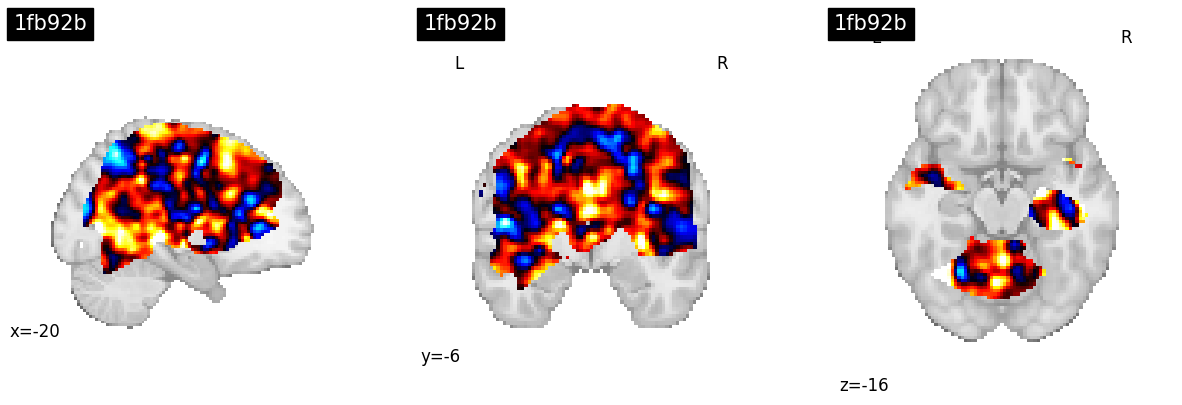

Cluster [10] - Medoid [b91e5894cff6202ca4234c7ad9e6a3a2d93ef79714585ab672e303d6aef4a65a]


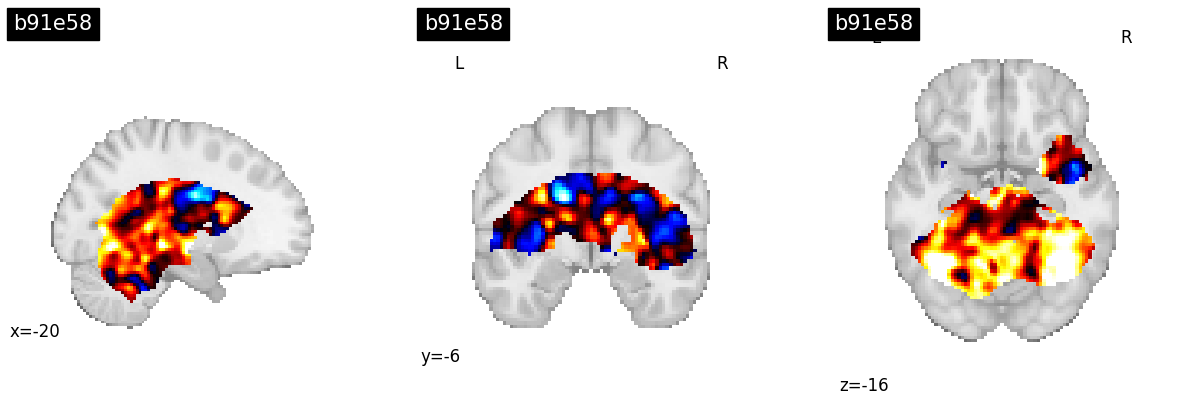

Cluster [10] - Antimedoid


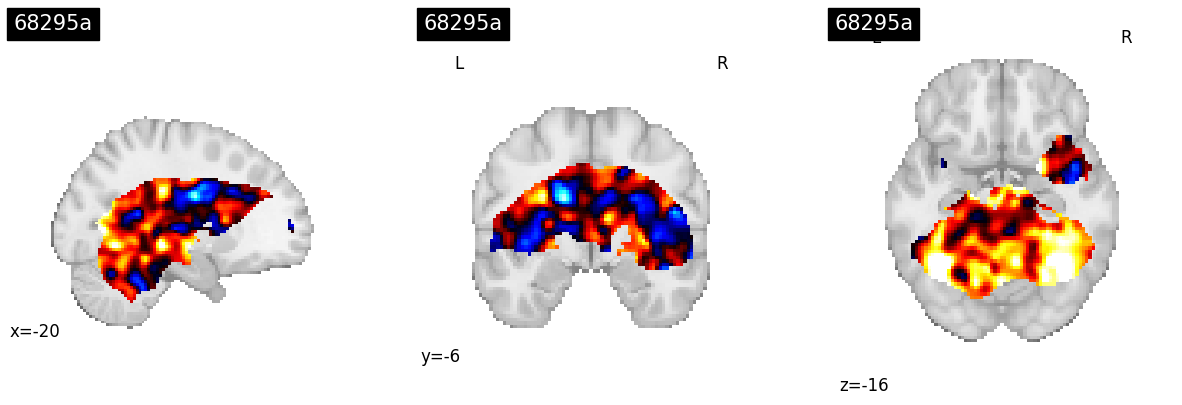

Cluster [11] - Medoid [7963d9ea2e69c64e5ee8bf6bc4c8bf4276e9eb0b45686c485e40438d05f5757b]


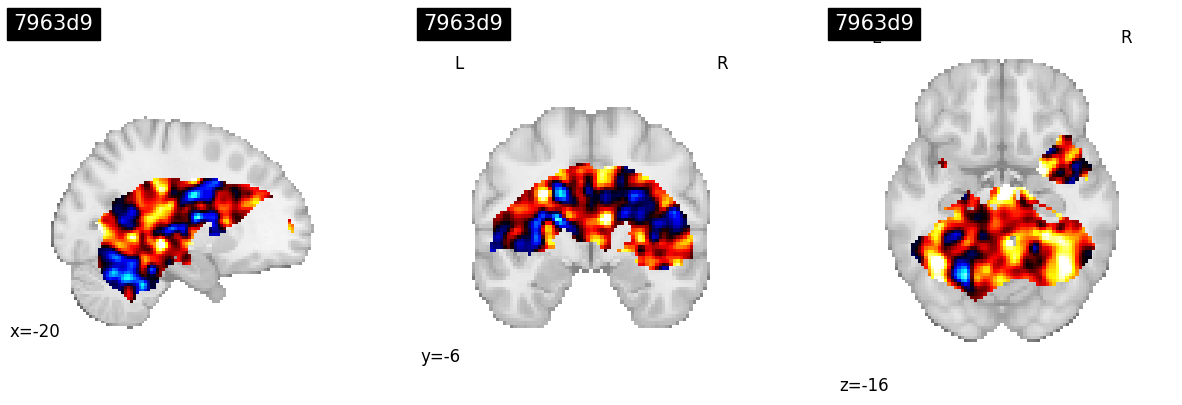

Cluster [11] - Antimedoid


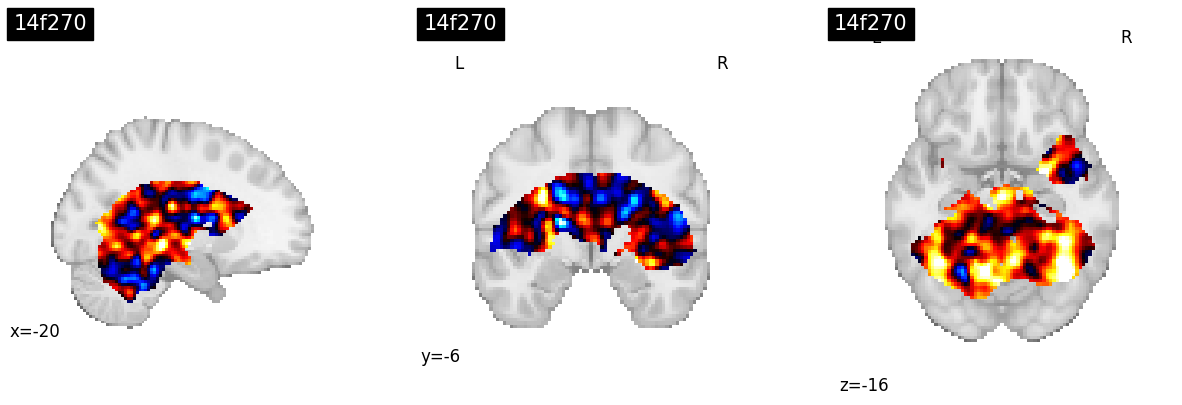

Cluster [12] - Medoid [23c2ad45cbfaf3bf1c6117e227e4519ff76fceed4af19b295d848a1ef736fcca]


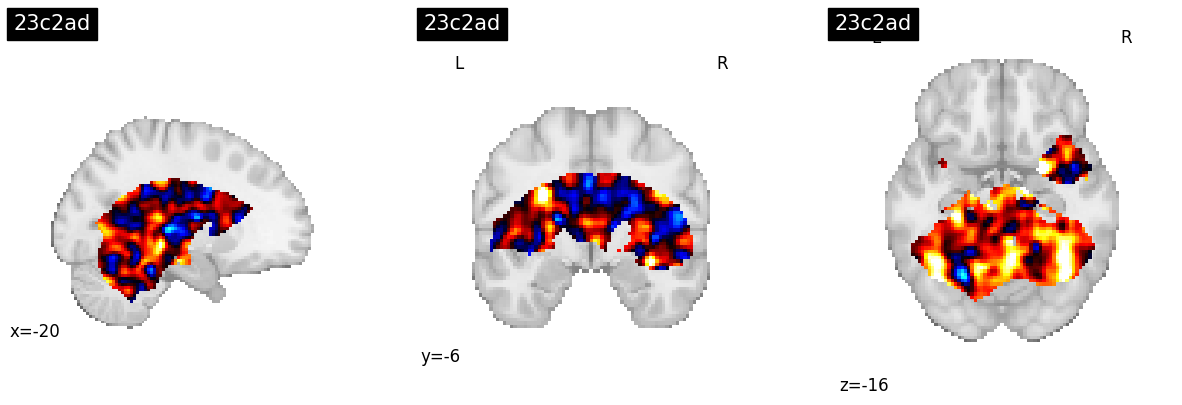

Cluster [12] - Antimedoid


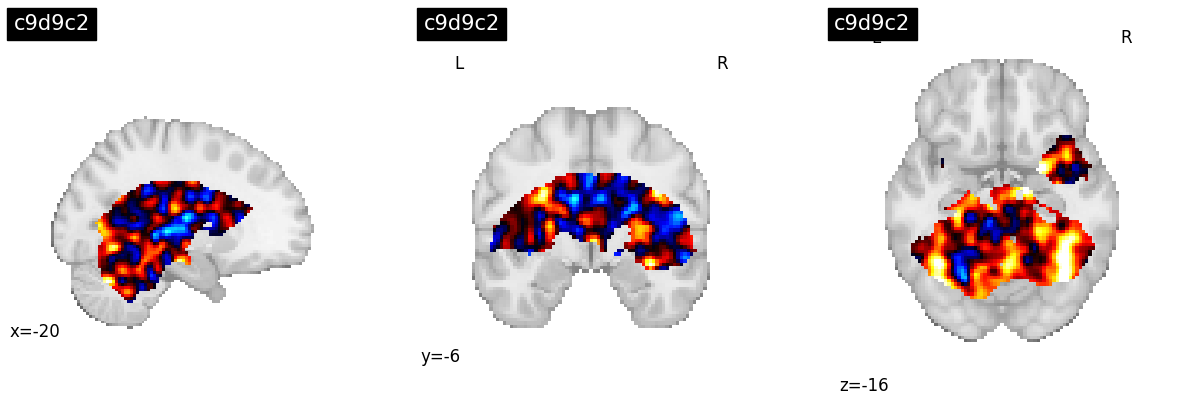

Cluster [13] - Medoid [47d5db645b0992d427e289e718ec58923ee35cb4adb939aff385030eb441c15c]


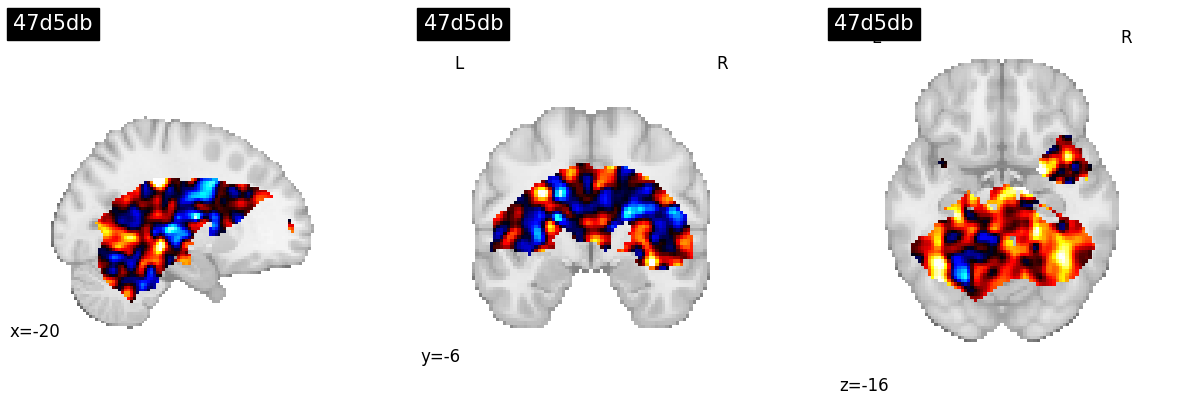

Cluster [13] - Antimedoid


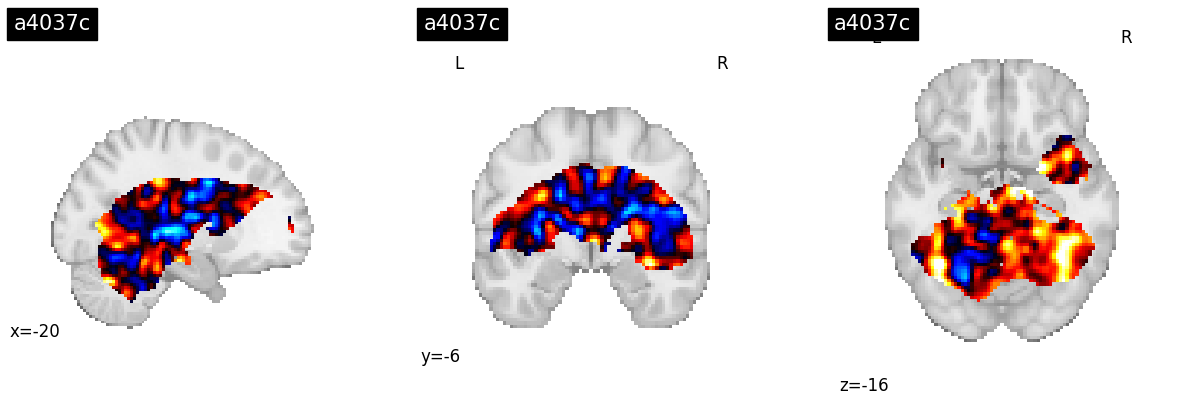

In [13]:
from plot_utils import plot_brain

threshold = 0.95
medoids = df_results.loc[df_results['threshold'] == threshold, 'medoids'].values[0]
medoids = {k: medoids[k] for k in sorted(medoids)}
antimedoids = df_results.loc[df_results['threshold'] == threshold, 'antimedoids'].values[0]
for key, value in medoids.items():
    print(f"Cluster [{key}] - Medoid [{value}]")
    img_path = os.path.join(result_path, value, 'spmT_0001.nii')
    plot_brain(img_path, coords, ref_path=None)
    print(f"Cluster [{key}] - Antimedoid")
    img_path = os.path.join(result_path, antimedoids[key], 'spmT_0001.nii')
    plot_brain(img_path, coords, ref_path=None)

# Filter incorrect configs
- Cluster by t
- Display medoids
- Eliminate cluster by medoids

In [15]:
excluding_medoids = []

for key, value in medoids.items():
    if key not in [1, 2, 3]:
        excluding_medoids.append(value)

print(f"Excludes {len(excluding_medoids)} clusters")

threshold = 0.95
ds, matrix, Z, clusters = clusterize_hierch(dataset, correlations, dataset['id'], None, corr_func, threshold)

print(f"Threshold = {threshold} - Clusters = {len(clusters.unique())}")

clusters_to_exclude = set()
for medoid in excluding_medoids:
    cluster = ds.loc[ds['id'] == medoid, 'cluster'].values
    if len(cluster) > 0:
        clusters_to_exclude.add(cluster[0])

acceptable_dataset = ds[~ds['cluster'].isin(clusters_to_exclude)]
acceptable_dataset = acceptable_dataset.drop(columns=['cluster'])
acceptable_dataset.to_csv(os.path.join(datadir, 'acceptable_dataset.csv'), index=False)
print(f"Acceptabes : {len(acceptable_dataset)}")

unacceptable_dataset = ds[ds['cluster'].isin(clusters_to_exclude)]
unacceptable_dataset = unacceptable_dataset.drop(columns=['cluster'])
unacceptable_dataset.to_csv(os.path.join(datadir, 'unacceptable_dataset.csv'), index=False) 
print(f"Unacceptabes : {len(unacceptable_dataset)}")

filtered_dataset = acceptable_dataset.copy()

Excludes 10 clusters
Threshold = 0.95 - Clusters = 13
Acceptabes : 380
Unacceptabes : 620


In [ ]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Plot the dendrogram (optional, for visualization)
plt.figure(figsize=(10, 5))
dendrogram(Z, truncate_mode='lastp', p=50)  # Show last 50 merges
plt.title('Dendrogram')
plt.show()

# PCA
distance_matrix = 1 - matrix
pca = PCA(n_components=2)
pca_result = pca.fit_transform(dataset)
plt.figure(figsize=(10, 6))
sb.scatterplot(
    x=pca_result[:, 0], y=pca_result[:, 1],
    hue=clusters,
    palette='tab20',
    alpha=0.7
)
plt.title('PCA Plot of Clusters')
plt.show()

# t-SNE

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(dataset)
print(len(tsne_result))

## Distribution from_ref for acceptable/unacceptable

{'min': np.float64(0.7708958826728557), 'max': np.float64(1.0), 'mean': np.float64(0.9002456708658317)}
{'min': np.float64(0.2042360517907814), 'max': np.float64(0.5857264211530007), 'mean': np.float64(0.31339896138932394)}


/home/ymerel/tmp/ipykernel_23822/590727294.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


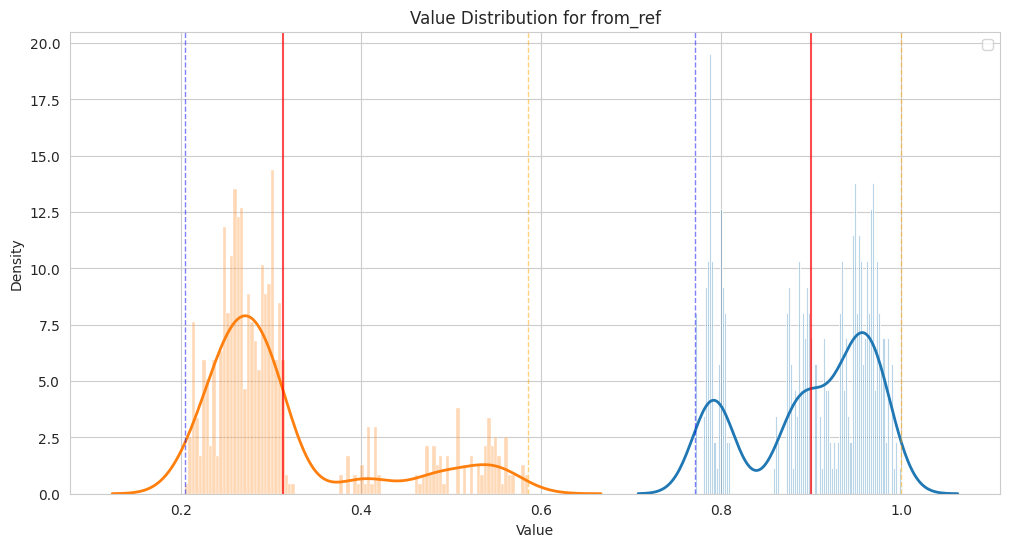

In [52]:
# Create a dictionary to loop over the datasets
datasets = {
    'Acceptable': acceptable_dataset,
    'Unacceptable': unacceptable_dataset
}

# Calculate min, max, and mean for each dataset
stats = {}
for label, df in datasets.items():
    stats[label] = {
        'min': df['from_ref'].min(),
        'max': df['from_ref'].max(),
        'mean': df['from_ref'].mean()
    }
    print(stats[label])

# Plot
plt.figure(figsize=(12, 6))
for label, df in datasets.items():
    sb.histplot(
        df['from_ref'],
        bins=100,
        alpha=0.3,
        label='',
        kde=False,
        stat='density'
    )
    sb.kdeplot(
        df['from_ref'],
        label='',
        linewidth=2
    )
    # Add vertical lines for min, max, and mean
    plt.axvline(stats[label]['min'], color='blue', linestyle='--', alpha=0.5, linewidth=1, label=f'')
    plt.axvline(stats[label]['max'], color='orange', linestyle='--', alpha=0.5, linewidth=1, label=f'')
    plt.axvline(stats[label]['mean'], color='red', linestyle='-', alpha=0.7, linewidth=1.5, label=f'')

plt.title('Value Distribution for from_ref')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

accuracy: 1.0 , recall: 1.0


/home/ymerel/tmp/ipykernel_23822/2666558622.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_importances_df, palette='viridis')


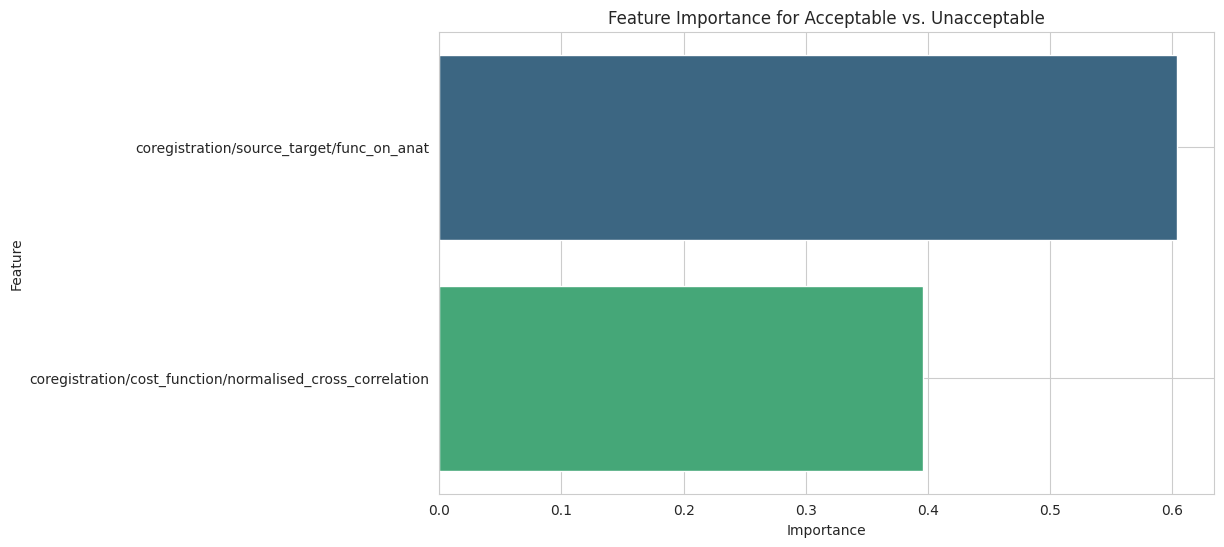

In [18]:
from sklearn import tree
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz


def analyze_feature_importance(acceptable, unacceptable, train_size=0.7):
    # Combine datasets and add a binary target column
    acceptable['target'] = 0  # 0 for acceptable
    unacceptable['target'] = 1  # 1 for unacceptable
    combined = pd.concat([acceptable, unacceptable])

    # Drop non-feature columns (e.g., 'id')
    ignored = [col for col in combined.columns if col.startswith('from_') or col in ['id', 'target']]
    features = combined.drop(columns=ignored).columns
    X = combined[features]
    y = combined['target']

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=train_size, random_state=42
    )

    # Train a Decision Tree classifier
    classifier = DecisionTreeClassifier(random_state=42)
    classifier.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = classifier.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    print(f"accuracy: {report['accuracy']} , recall: {report['macro avg']['recall']}")

    # Extract feature importances
    importances = classifier.feature_importances_
    feat_importances = pd.DataFrame({
        'Feature': features,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    importances = classifier.feature_importances_
    feat_importances = dict()
    for i, feat in enumerate(features):
        if importances[i] > 0.0:
            feat_importances[feat] = importances[i]
    results['feature_importances'] = feat_importances
    
    dot_data = tree.export_graphviz(classifier, out_file=None,
     feature_names=X_train.columns.values,
     filled=True, rounded=True,
     special_characters=True,
     leaves_parallel=True, proportion=True)
    graph = graphviz.Source(dot_data)
    graph.render(f"unacceptable_vs_acceptable")
    
    return feat_importances

feat_importances_df = pd.DataFrame(
    list(analyze_feature_importance(acceptable_dataset, unacceptable_dataset).items()),
    columns=['Feature', 'Importance']
)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importances_df, palette='viridis')
plt.title('Feature Importance for Acceptable vs. Unacceptable')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(True)
plt.show()



## [Filtered] Cluster by threshold

In [40]:
all_results = []

print(len(filtered_dataset))

thresholds = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.5, 0.55, 0.60, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

for threshold in thresholds:
    results = dict()
    results['threshold'] = threshold
    # cluster on whole dataset
    ds, matrix, Z, clusters =  clusterize_hierch(filtered_dataset, correlations, filtered_dataset['id'], None, corr_func, threshold)
    results['clusters'] = len(np.unique(clusters.values)) 
    
    distance_matrix = 1 - matrix
    densities = get_cluster_distance_densities(distance_matrix.values, clusters.values)
    results['mean_density'] = np.mean(list(densities.values()))
    results['cophenetic'] = get_cluster_cophenetic(Z, distance_matrix.values)
    results['silhouette'] = get_cluster_silhouette(distance_matrix.values, clusters.values)
    results['davies_bouldin'] = get_davies_bouldin(distance_matrix.values, clusters.values)
    results['inertia'] = get_cluster_inertia(distance_matrix.values, clusters.values)
    results['medoids'] = get_medoids(distance_matrix, clusters)
    results['antimedoids'] = get_antimedoids(distance_matrix, clusters)

        
    # predict on 70 % train dataset
    merged_results = results | predict_clusters(filtered_dataset, correlations, None, corr_func, threshold, 0.7)
    all_results.append(merged_results)

df_by_thresh = pd.DataFrame(all_results)
df_results = df_by_thresh
df_by_thresh.head(20)

380


,threshold,clusters,mean_density,cophenetic,silhouette,davies_bouldin,inertia,medoids,antimedoids,train_size,accuracy,recall,decision_tree,feature_importances
0,0.05,36,0.013200,0.940887,0.480390,0.987314,0.813626,{26: '006fb38da122f3aa516a611c695294f915f1508f...,{26: '73f58b4b40fd50331130902dbdf5c93307cb8889...,0.7,0.973684,0.969444,"digraph Tree {\nnode [shape=box, style=""filled...",{'signal_modeling/nuisance_regressors': 0.0581...
1,0.10,18,0.019532,0.940887,0.444032,0.967328,3.389472,{10: '8e7a3fb09a6004de3f0afe2851c25be3282d4b51...,{10: '73f58b4b40fd50331130902dbdf5c93307cb8889...,0.7,0.991228,0.981481,"digraph Tree {\nnode [shape=box, style=""filled...",{'signal_modeling/nuisance_regressors': 0.0805...
2,0.15,10,0.025978,0.940887,0.418066,1.041289,10.270424,{6: '8e7a3fb09a6004de3f0afe2851c25be3282d4b51f...,{6: 'da5c82c47e4e920a05b950df524b3f676d61c4dc0...,0.7,0.991228,0.975000,"digraph Tree {\nnode [shape=box, style=""filled...",{'signal_modeling/nuisance_regressors': 0.1397...
3,0.20,8,0.028383,0.940887,0.524828,0.959201,16.653623,{5: '8e7a3fb09a6004de3f0afe2851c25be3282d4b51f...,{5: 'da5c82c47e4e920a05b950df524b3f676d61c4dc0...,0.7,0.991228,0.968750,"digraph Tree {\nnode [shape=box, style=""filled...",{'signal_modeling/nuisance_regressors': 0.2390...
4,0.25,6,0.029993,0.940887,0.503318,1.038759,29.204190,{2: 'c905c1433412e29aff4228bf261ed93e3a141088f...,{2: 'da5c82c47e4e920a05b950df524b3f676d61c4dc0...,0.7,0.991228,0.990741,"digraph Tree {\nnode [shape=box, style=""filled...",{'signal_modeling/nuisance_regressors': 0.2669...
5,0.30,5,0.031171,0.940887,0.532757,0.867084,46.534357,{2: 'b10ba27b41c72cecd805fe36c225741ff4fd50f1f...,{2: 'f16d9fe0be02758f93babb75adea3d1ecb0129bc9...,0.7,1.000000,1.000000,"digraph Tree {\nnode [shape=box, style=""filled...",{'signal_modeling/nuisance_regressors/motion':...
6,0.35,4,0.035529,0.940887,0.550022,0.799056,61.457301,{1: 'b10ba27b41c72cecd805fe36c225741ff4fd50f1f...,{1: 'f16d9fe0be02758f93babb75adea3d1ecb0129bc9...,0.7,1.000000,1.000000,"digraph Tree {\nnode [shape=box, style=""filled...",{'signal_modeling/nuisance_regressors/motion':...
7,0.40,4,0.035529,0.940887,0.550022,0.799056,61.457301,{1: 'b10ba27b41c72cecd805fe36c225741ff4fd50f1f...,{1: 'f16d9fe0be02758f93babb75adea3d1ecb0129bc9...,0.7,1.000000,1.000000,"digraph Tree {\nnode [shape=box, style=""filled...",{'signal_modeling/nuisance_regressors/motion':...
8,0.45,4,0.035529,0.940887,0.550022,0.799056,61.457301,{1: 'b10ba27b41c72cecd805fe36c225741ff4fd50f1f...,{1: 'f16d9fe0be02758f93babb75adea3d1ecb0129bc9...,0.7,1.000000,1.000000,"digraph Tree {\nnode [shape=box, style=""filled...",{'signal_modeling/nuisance_regressors/motion':...
9,0.50,3,0.038439,0.940887,0.637069,0.433531,134.049269,{1: 'b10ba27b41c72cecd805fe36c225741ff4fd50f1f...,{1: '3a9f642fc69e25b0249c29200e88afa8956cd7285...,0.7,1.000000,1.000000,"digraph Tree {\nnode [shape=box, style=""filled...",{'signal_modeling/nuisance_regressors/motion':...


## [Filtered] Print all metrics
- Cophenetic correlation: > 0.75 = good ; < 0.75 = poor
- Silhouette score: -1 = worst ; 1 = best
- Davies-Bouldin index: < 1 = good
- Inertia: lower = tighter

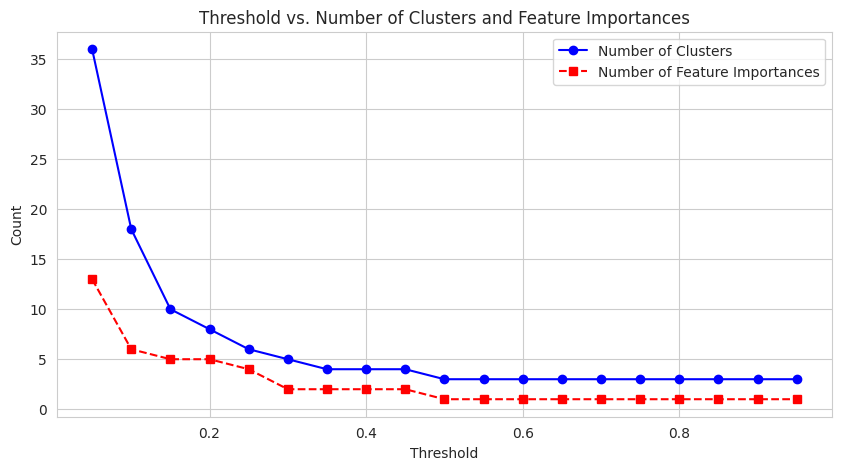

In [41]:
import matplotlib.pyplot as plt

# Add a new column to count the number of feature importances for each threshold
df_results['num_feature_importances'] = df_results['feature_importances'].apply(lambda x: len(x))

# Plot threshold vs. number of clusters
plt.figure(figsize=(10, 5))
plt.plot(df_results['threshold'], df_results['clusters'], marker='o', linestyle='-', color='b', label='Number of Clusters')

# Plot threshold vs. number of feature importances
plt.plot(df_results['threshold'], df_results['num_feature_importances'], marker='s', linestyle='--', color='r', label='Number of Feature Importances')

plt.title('Threshold vs. Number of Clusters and Feature Importances')
plt.xlabel('Threshold')
plt.ylabel('Count')
plt.grid(True)
plt.legend()
plt.show()

# [Filtered] Feature importances

/home/ymerel/tmp/ipykernel_23822/3371223150.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Importance', y='Feature', data=feat_importances_df, palette='viridis')


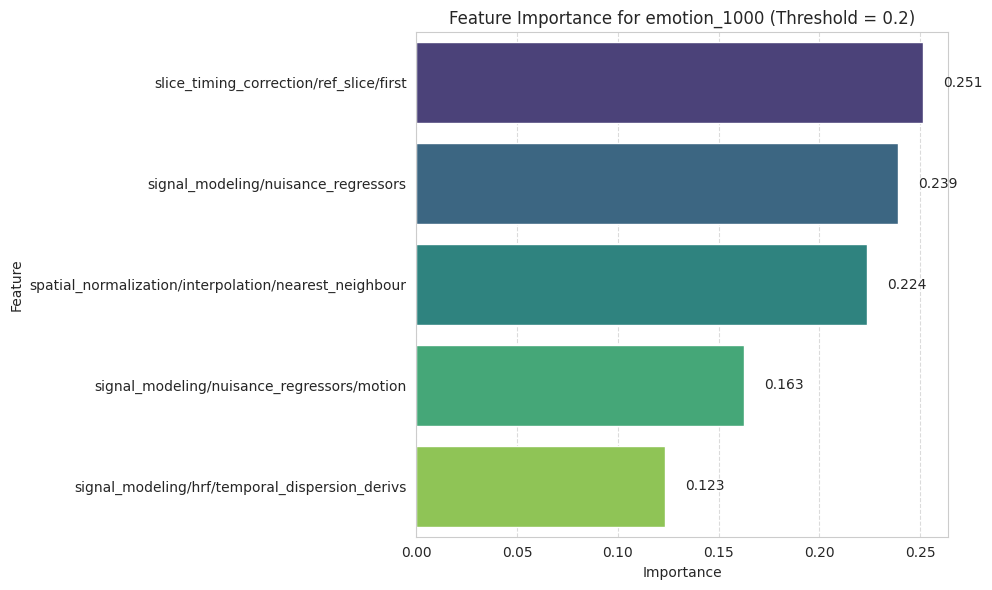

In [53]:
import pandas as pd1
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

threshold=0.20

# Extract feature importances for threshold == 0.10
feat_importances_dict = df_results.loc[df_results['threshold'] == threshold, 'feature_importances'].values[0]

# Convert to DataFrame and sort by importance (descending)
feat_importances_df = pd.DataFrame(
    list(feat_importances_dict.items()),
    columns=['Feature', 'Importance']
).sort_values(by='Importance', ascending=False)

# Render decision tree
graph = graphviz.Source(df_results.loc[df_results['threshold'] == threshold, 'decision_tree'].values[0])

graph.render(f"emotion")

# Plot feature importances
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Importance', y='Feature', data=feat_importances_df, palette='viridis')

# Display the importance values on the bars
for p in ax.patches:
    width = p.get_width()
    plt.text(width + 0.01,  # x position (slightly right of the bar)
             p.get_y() + p.get_height() / 2,  # y position (center of the bar)
             f'{width:.3f}',  # text to display (formatted to 3 decimal places)
             ha='left',  # horizontal alignment
             va='center')  # vertical alignment

plt.title(f'Feature Importance for {jobname} (Threshold = {threshold})')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Cluster [1] - Medoid [b10ba27b41c72cecd805fe36c225741ff4fd50f1f9f734d027a7de9a13d74ad5]


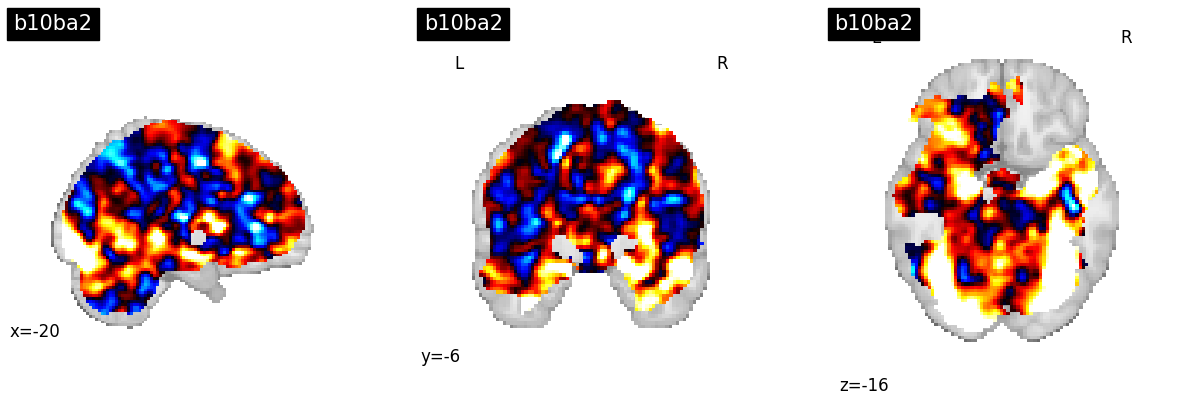

Cluster [1] - Antimedoid


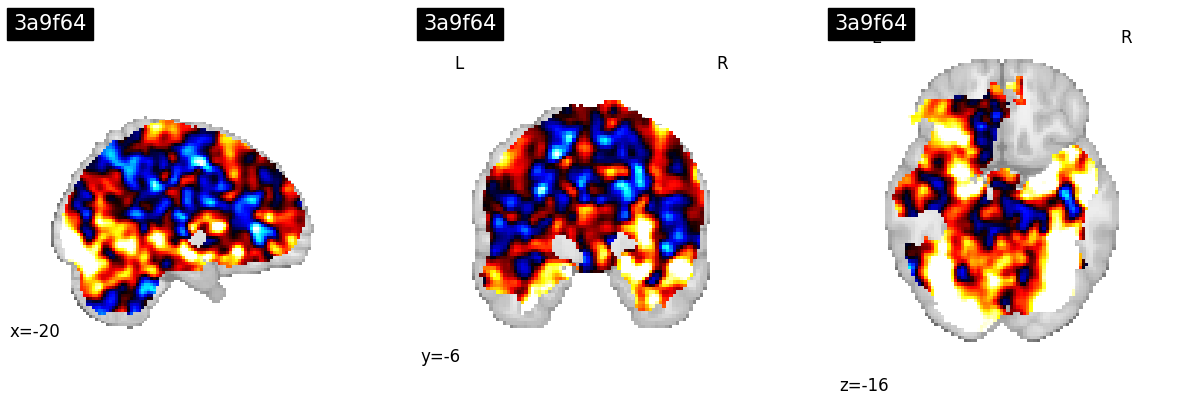

Cluster [2] - Medoid [9111a94c1a55f876b2a92dfa6466af0879e5b3487240c5ebf816502c3366b1d5]


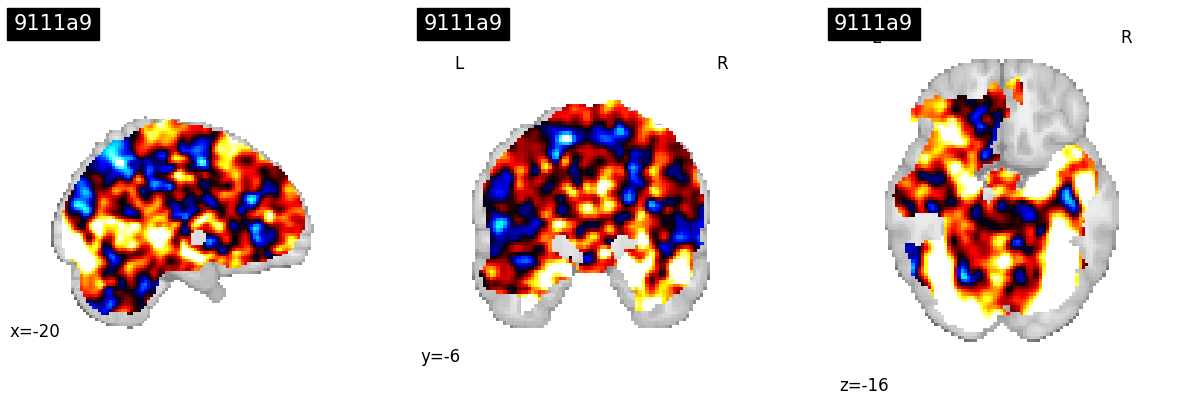

Cluster [2] - Antimedoid


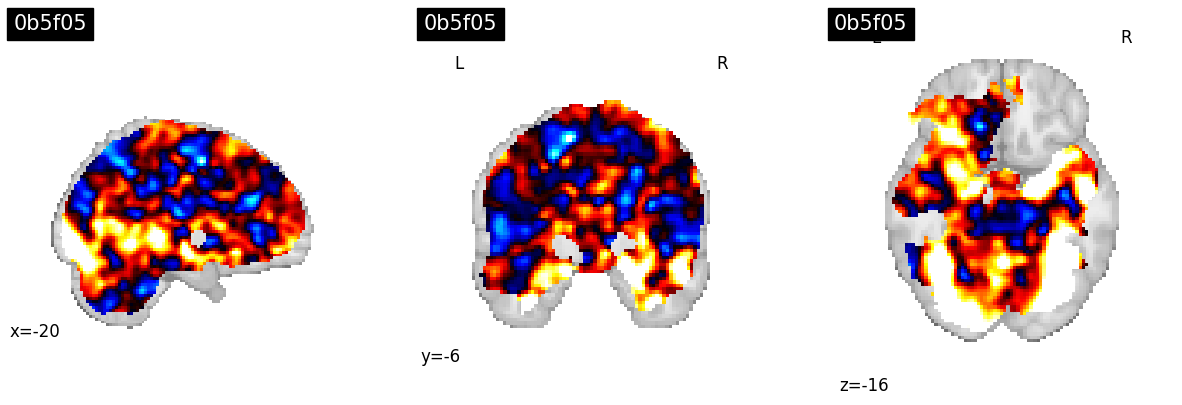

Cluster [3] - Medoid [175aba5e213089daa24c32d5cb3c34193538db2a394fe7956eec838c924b11d5]


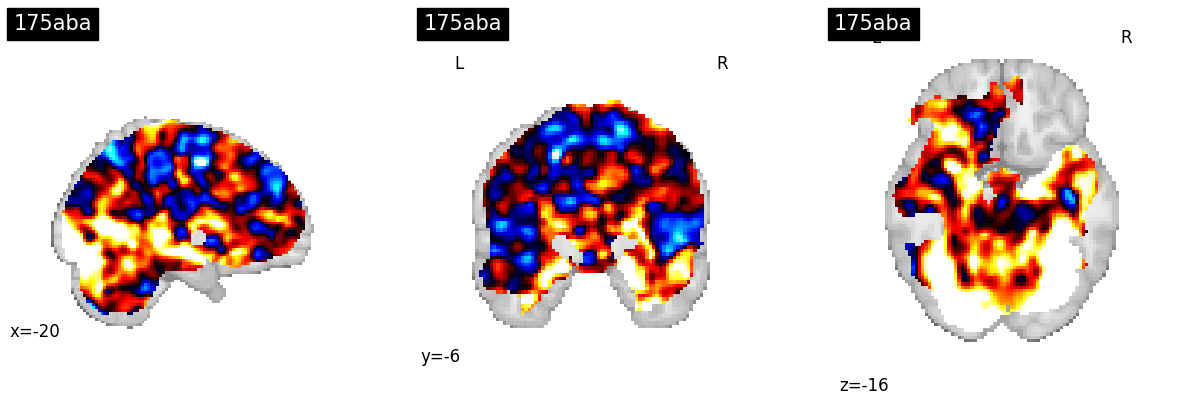

Cluster [3] - Antimedoid


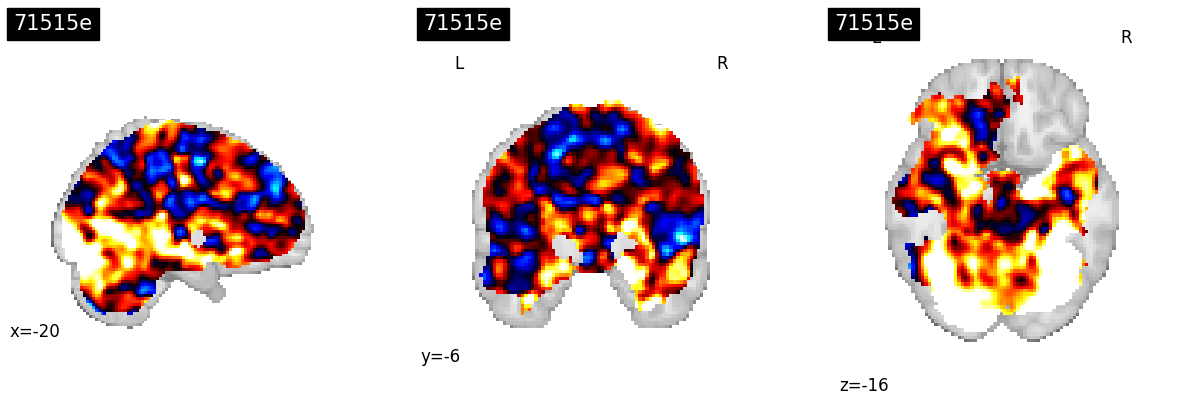

In [47]:
from plot_utils import plot_brain

medoids = df_results.loc[df_results['threshold'] == threshold, 'medoids'].values[0]
medoids = {k: medoids[k] for k in sorted(medoids)}
antimedoids = df_results.loc[df_results['threshold'] == threshold, 'antimedoids'].values[0]
for key, value in medoids.items():
    print(f"Cluster [{key}] - Medoid [{value}]")
    img_path = os.path.join(result_path, value, 'spmT_0001.nii')
    plot_brain(img_path, coords, ref_path=None)
    print(f"Cluster [{key}] - Antimedoid")
    img_path = os.path.join(result_path, antimedoids[key], 'spmT_0001.nii')
    plot_brain(img_path, coords, ref_path=None)

In [ ]:
import pydot

# Extract the DOT source from the graphviz.Source object
dot_source = graph.source
# Load the DOT source into pydot
graph_pydot = pydot.graph_from_dot_data(dot_source)[0]
for node in graph_pydot.get_nodes():
    print(node.get_sequence())
    node.get_port()
for edge in graph_pydot.get_edges():
    print(edge)